# Build simple graph using LangGraph

In [ ]:
from typing import TypedDict, Literal

class demostate(TypedDict):
    name: str
    count: float
    msg: str

In [32]:
def f1(state: demostate) -> demostate:
    state["count"] += 1
    name = state['name']
    state['msg'] = f"Hello, {name}!"
    return state

def f2(state: demostate) -> demostate:
    state['count'] += 1
    state['msg'] = f"Goodbye, {state['name']}!"
    return state


In [33]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(demostate)

builder.add_node("node1", f1)
builder.add_node("node2", f2)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node2", END)

graph = builder.compile()

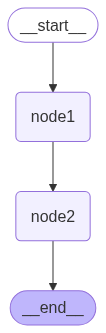

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
graph.invoke({"name": 'mayur', "count": 0})

{'name': 'mayur', 'count': 2, 'msg': 'Goodbye, mayur!'}

# Graph with condition

In [36]:
from typing import TypedDict, Literal

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal["INR", "EUR"]
    total: float


In [37]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 85
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

In [38]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        "INR": "convert_to_inr_node",
        "EUR": "convert_to_eur_node",
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

graph = builder.compile()

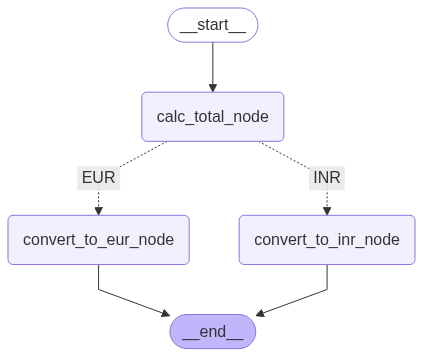

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:

graph.invoke({"amount_usd": 1000, "target_currency": "INR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'INR',
 'total': 91800.0}

# Chatbot using langgraph

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
load_dotenv()

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")
# llm.invoke("Tell me a joke about AI agents.")

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")

In [9]:
graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile()

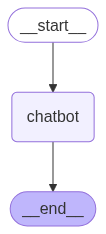

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hey there! How can I help you today?
Assistant: I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning as intended and ready to assist you with any questions or tasks you have. How can I help you today?
Assistant: Please provide me with the text you would like me to analyze, summarize, translate, or answer questions about. I need the text to be able to help you.
Assistant: Please provide me with some context! I need to know what you'd like me to do with this prompt.  For example, are you asking me to:

*   **Write a story?**
*   **Answer a question?**
*   **Create a poem?**
*   **Generate a list?**
*   **Something else entirely?**

The more information you give me, the better I can understand your request and provide a helpful response.


# Graph with a tool call

In [42]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [43]:
from dotenv import load_dotenv
load_dotenv()

True

In [44]:

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [45]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

C:\Users\mayur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


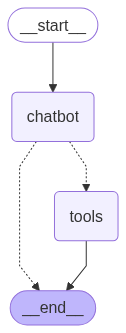

In [46]:

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:

state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [48]:

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

200.3


# Tool call agent

In [49]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [50]:
from dotenv import load_dotenv
load_dotenv()

True

In [51]:

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [52]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

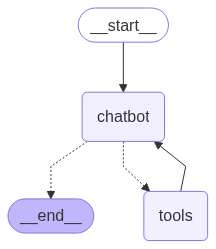

In [53]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [54]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

The current price of AAPL stock is $100.4.


In [55]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

OK. The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
Therefore, the total cost for both is $3000 + $3004.5 = $6004.5.


# Agents with memory

In [56]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [57]:

from dotenv import load_dotenv
load_dotenv()

True

In [58]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [59]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [60]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

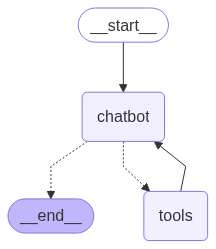

In [61]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
config1 = { 'configurable': { 'thread_id': '1'} }

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
Therefore, the total cost for both is $3000 + $3004.5 = $6004.5.


In [63]:
config2 = { 'configurable': { 'thread_id': '2'} }

msg = "Tell me the current price of 5 AAPL stocks."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one AAPL stock is $100.4. Therefore, the current price of 5 AAPL stocks is $502.


In [64]:

msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price for RIL is $87.6.
The total cost for 10 RIL stocks is 10 * $87.6 = $876.
Adding this to the previous total cost of $6004.5, the new total is $6004.5 + $876 = $6880.5.


In [65]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the current price of 5 MSFT stocks is $1001. Adding that to the previous total of $502, the new total is $1503.


# Langsmith Tracing

In [72]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [73]:
from dotenv import load_dotenv
load_dotenv()

True

In [74]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [75]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

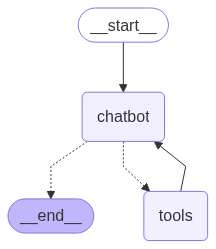

In [76]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]})
    return state["messages"][-1].content

call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?")

'The current price of AMZN is $150 and MSFT is $200.3.\nThe total cost for 20 AMZN stocks is 20 * $150 = $3000.\nThe total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.\nTherefore, the total cost for both is $3000 + $3004.5 = $6004.5.'

# Human In the Loop

In [79]:
from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command


class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol'''
    return {"MSFT": 200.3, "AAPL": 100.4, "AMZN": 150.0, "RIL": 87.6}.get(symbol, 0.0)

@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."


tools = [get_stock_price, buy_stocks]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

def chatbot_node(state: State):
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

memory = MemorySaver()
builder = StateGraph(State)
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "buy_thread"}}

# Step 1: user asks price
state = graph.invoke({"messages":[{"role":"user","content":"What is the current price of 10 MSFT stocks?"}]}, config=config)
print(state["messages"][-1].content)

# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state.get("__interrupt__"))

decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)




The current price of one MSFT stock is $200.3. Therefore, the current price of 10 MSFT stocks is $2003.
[Interrupt(value='Approve buying 10 MSFT stocks for $2003.00?', resumable=True, ns=['tools:676b920b-dc4d-c6d3-ea62-bb9d97234385'])]
I am sorry, I was not able to buy 10 MSFT stocks at the current price. The transaction was declined.
